## Problem Statement:

Forecasting the daily climate of Delhi from the year 2013 to 2017 using the variables such as mean temperature, humidity, wind speed and mean pressure. 

## Importing Required Libraries :

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
from datetime import datetime,timedelta
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error
from statsmodels.tsa.api import SimpleExpSmoothing,Holt,ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARMA,ARIMA
from statsmodels.graphics.gofplots import qqplot
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.api                  import  VAR
from statsmodels.tsa.statespace.varmax    import  VARMAX
sns.set_style('whitegrid')
from warnings import filterwarnings
filterwarnings("ignore")

In [277]:
df_climate1=pd.read_csv("DailyDelhiClimateTrain.csv",parse_dates=['date'])

In [278]:
df_climate2=pd.read_csv("DailyDelhiClimateTest.csv",parse_dates=['date'])

In [279]:
df_climate=pd.concat([df_climate1,df_climate2])
df_climate.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [280]:
# Making the date column as index 
df_climate.set_index(['date'],inplace=True)

In [281]:
df_climate.shape

(1576, 4)

###### Inference : There are 1576 rows and 4 columns .

In [267]:
df_climate.isnull().sum()

meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

###### Inference : There are no null values present in the dataset.

## Forecasting:

##### There are 2 ways of Forecasting :

#####    1. Univariate Forecasting
    
#####    2. Multivariate Forecasting

## Univariate Forecasting :

###### Considering only mean temperature variable for forecasting

In [268]:
df_uni=df_climate[['meantemp']]
df_uni

,meantemp
date,
2013-01-01,10.000000
2013-01-02,7.400000
2013-01-03,7.166667
2013-01-04,8.666667
2013-01-05,6.000000
...,...
2017-04-20,34.500000
2017-04-21,34.250000
2017-04-22,32.900000


In [9]:
df_uni.tail()

,meantemp
date,
2017-04-20,34.500
2017-04-21,34.250
2017-04-22,32.900
2017-04-23,32.875
2017-04-24,32.000


In [10]:
df_uni.sort_index(inplace=True)

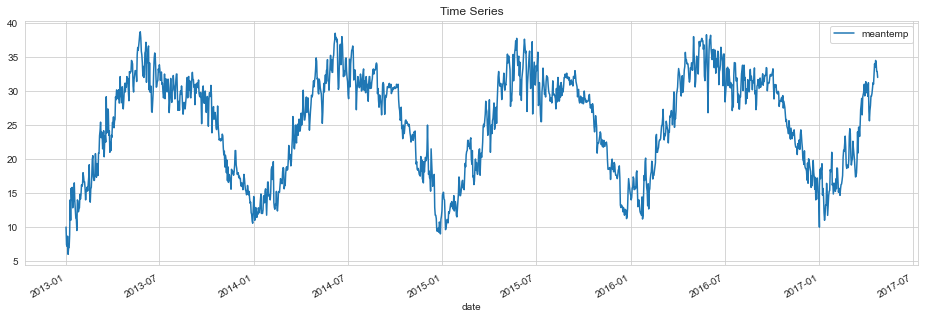

In [11]:
# Checking the plot of the time series.
rcParams["figure.figsize"]=16,5
df_uni.plot()
plt.title("Time Series")
plt.show()

###### Inference: As per the plot above there seems to be no trend present which shows an abrupt increase or decrease in temperature in each year. However there is seasonality present which shows a pattern in which the climate increases and decreases each year.

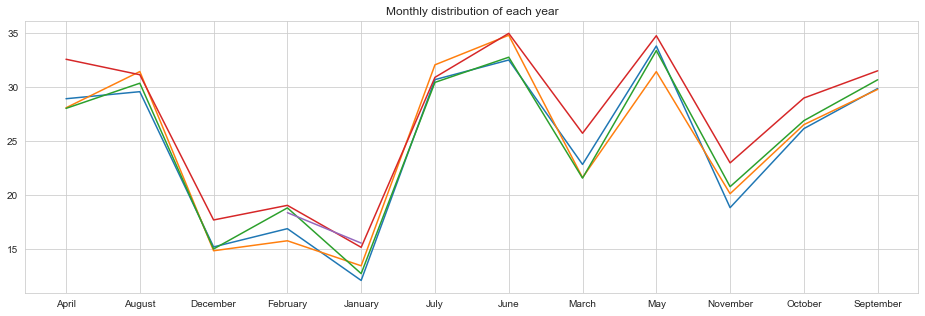

In [12]:
plt.plot(pd.pivot_table(df_uni,values='meantemp',columns=df_uni.index.year,index=df_uni.index.month_name()))
plt.title("Monthly distribution of each year")
plt.show()


###### Inference : The pattern in each year seems to be the very similar where the temperature is the lowest during January every year and the highest during May and June.

## Decomposition:

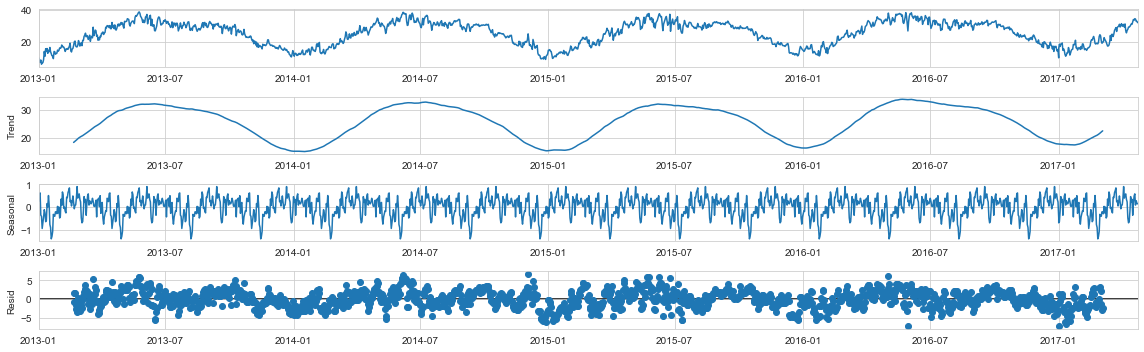

In [13]:
decompose=seasonal_decompose(df_uni,period=100,model='aditive')
decompose.plot()
plt.show()

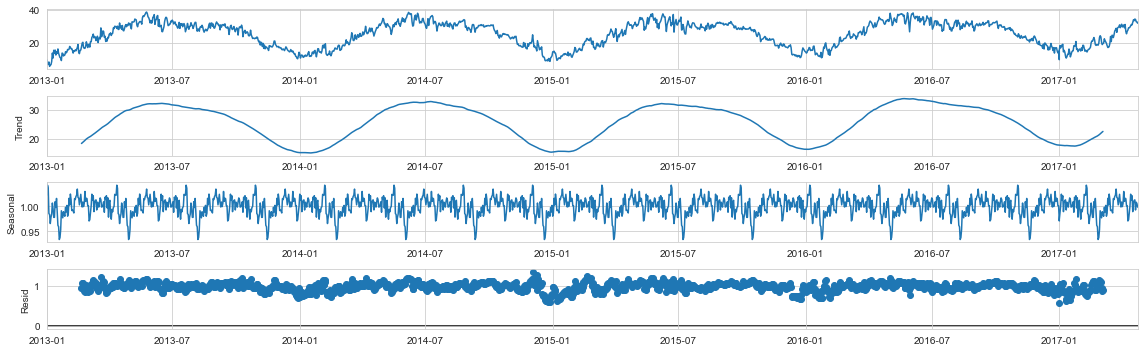

In [14]:
decompose=seasonal_decompose(df_uni,period=100,model='multiplicative')
decompose.plot()
plt.show()

###### Inference : Both additive and multiplicative decomposition give the same inference regarding the trend and seasonality i.e. they both have obvious patterns. However the residuals in the additive decomposition are more distributed as compared to multiplicative decomposition.

## Splitting time series for Train & Test:

In [15]:
train_end=datetime(2015,12,31)
test_end=datetime(2017,4,24)
train=df_uni[:train_end]
test=df_uni[train_end+timedelta(days=1):test_end]
print("Train:\n",train)
print("Test:\n",test)

Train:
              meantemp
date                 
2013-01-01  10.000000
2013-01-02   7.400000
2013-01-03   7.166667
2013-01-04   8.666667
2013-01-05   6.000000
...               ...
2015-12-27  15.375000
2015-12-28  17.125000
2015-12-29  16.375000
2015-12-30  15.500000
2015-12-31  15.000000

[1095 rows x 1 columns]
Test:
              meantemp
date                 
2016-01-01  14.714286
2016-01-02  14.000000
2016-01-03  14.375000
2016-01-04  15.750000
2016-01-05  15.833333
...               ...
2017-04-20  34.500000
2017-04-21  34.250000
2017-04-22  32.900000
2017-04-23  32.875000
2017-04-24  32.000000

[481 rows x 1 columns]


## Defining Functions to find forecasting scores:

###### The metrics used are RMSE (Root Mean Square Error) and MAPE (Mean Average Percentage Error)

In [170]:
score_card=pd.DataFrame(columns=['Model','RMSE','MAPE'])
def update_score_card(algo_name,model):
    global score_card
    
    def rmse(model):
        pred=model.forecast(steps=len(test))
        rmse=mean_squared_error(test,pred,squared=False)
        return rmse
    
    def mape(model):
        pred=model.forecast(steps=len(test))
        mape=mean_absolute_percentage_error(test,pred)
        return mape
    
    score_card=score_card.append({'Model':algo_name,'RMSE':rmse(model),'MAPE':mape(model)},ignore_index=True)
    return score_card

## Forecasting Using Exponential Smoothing:

### 1.Simple Exonential Smoothing:

In [171]:
SE=SimpleExpSmoothing(train,initialization_method='estimated')
SimpleExp=SE.fit(smoothing_level=0.5,optimized=True)

In [172]:
SE_pred=SimpleExp.forecast(steps=len(test))

In [173]:
update_score_card("Simple Exponential",SimpleExp)

,Model,RMSE,MAPE
0,Simple Exponential,12.656961,0.370264


###### Inference: After Simple Exponential Smoothing RMSE value is 12.65 and MAPE is 0.37.

### 2. Double Exponential Smoothing / Holt:

In [174]:
DE=Holt(train,initialization_method='estimated')
DoubleExp=DE.fit(smoothing_level=0.5,optimized=True)

In [175]:
DE_pred=DoubleExp.forecast(steps=len(test))

In [176]:
update_score_card("Double Exponential",DoubleExp)

,Model,RMSE,MAPE
0,Simple Exponential,12.656961,0.370264
1,Double Exponential,11.578032,0.332991


###### Inference : With Double Exponential Smoothing the scores have reduced with RMSE 11.57 and MAPE as 0.33.

### 3.Triple Exponential Smoothing :

In [177]:
TE_add=ExponentialSmoothing(train,seasonal='additive',initialization_method='estimated')
TEExp_a=TE_add.fit(smoothing_level=0.5,optimized=True)

In [178]:
TEExp_a_pred=TEExp_a.forecast(steps=len(test))

In [179]:
update_score_card("Triple Exponential Additive Seasonality",TEExp_a)

,Model,RMSE,MAPE
0,Simple Exponential,12.656961,0.370264
1,Double Exponential,11.578032,0.332991
2,Triple Exponential Additive Seasonality,12.715798,0.372145


###### Inference : The scores have slightly increased.

In [180]:
TE_add=ExponentialSmoothing(train,seasonal='multiplicative',initialization_method='estimated')
TEExp_m=TE_add.fit(smoothing_level=0.5,optimized=True)

In [181]:
TEExp_m_pred=TEExp_m.forecast(steps=len(test))

In [182]:
update_score_card("Triple Exponential Multiplicative Seasonality",TEExp_m)

,Model,RMSE,MAPE
0,Simple Exponential,12.656961,0.370264
1,Double Exponential,11.578032,0.332991
2,Triple Exponential Additive Seasonality,12.715798,0.372145
3,Triple Exponential Multiplicative Seasonality,12.683938,0.371105


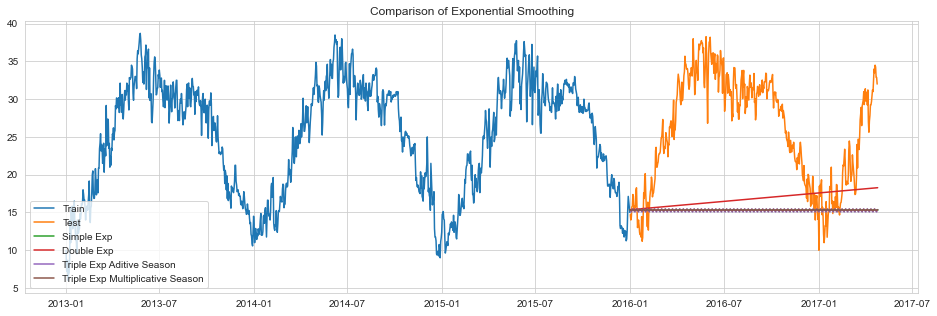

In [183]:
plt.plot(train,label='Train')
plt.plot(test,label='Test')
plt.plot(SE_pred,label='Simple Exp')
plt.plot(DE_pred,label='Double Exp')
plt.plot(TEExp_a_pred,label='Triple Exp Aditive Season')
plt.plot(TEExp_m_pred,label='Triple Exp Multiplicative Season')
plt.title('Comparison of Exponential Smoothing')
plt.legend()
plt.show()

###### Inference : The scores have reduced slightly but it is not the best .The Holt Exponential smoothing gives the best forecasting scores out of all smoothing models.

## Checking for stationarity in the Time series:

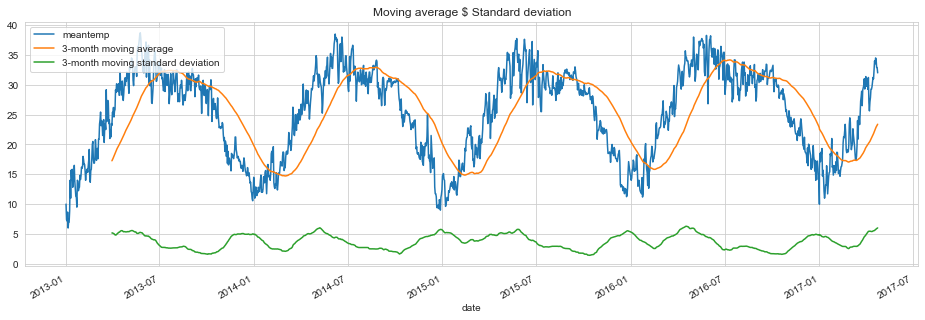

In [184]:
df_uni.plot()
plt.plot(df_uni.rolling(90).mean(),label="3-month moving average")
plt.plot(df_uni.rolling(90).std(),label="3-month moving standard deviation")
plt.legend()
plt.title("Moving average $ Standard deviation")
plt.show()

###### Inference: The plot above shows that the mean seems to remain constant during each year also the standard deviation almost remains the same. This means the time series may be stationary which is necessary for forecasting so that the model behaves the same using any sample of the time series.  

## Using Augmented Dicky Fuller Test to confirm stationarity :

H0: Time Series is not Stationary

H1: Time Series is Stationary

In [185]:
observations=df_uni.values
adf_test=adfuller(observations)
print("Test Statistic:",adf_test[0])
print("P-Value:",adf_test[1])
print("Citical Values:",adf_test[4])

Test Statistic: -2.379189948452089
P-Value: 0.1476962348979246
Citical Values: {'1%': -3.4345353407734733, '5%': -2.86338857621683, '10%': -2.567754150088293}


###### Inference: As per the statistical Test the time series is not stationary and needs to be made stationary by differencing

## 1st Order Differencing:

In [186]:
df_uni_diff=df_uni.diff().dropna()
df_uni_diff.head()

,meantemp
date,
2013-01-02,-2.600000
2013-01-03,-0.233333
2013-01-04,1.500000
2013-01-05,-2.666667
2013-01-06,1.000000


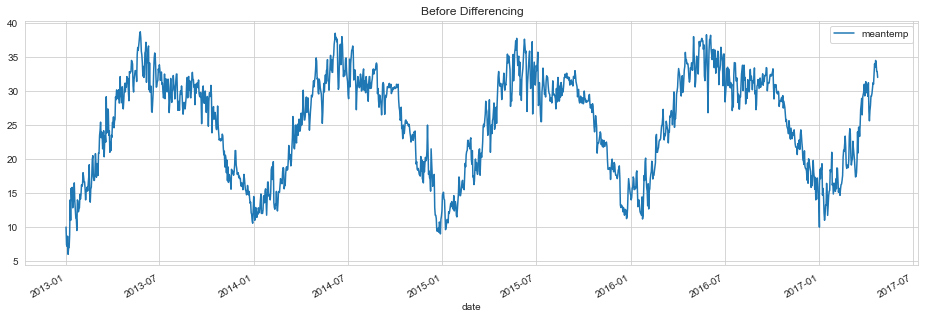

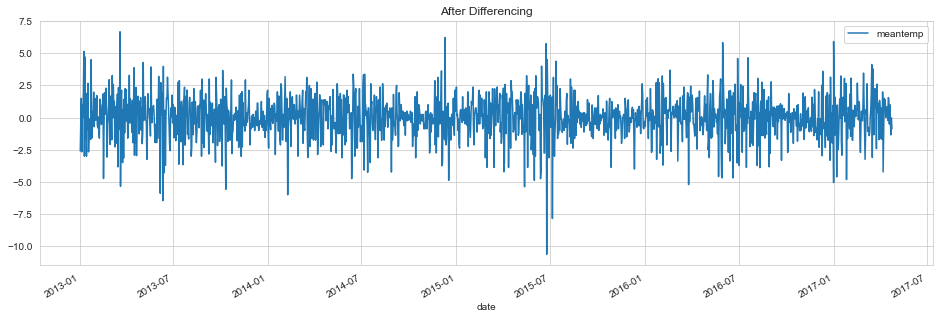

In [187]:
df_uni.plot()
plt.title("Before Differencing")
df_uni_diff.plot()
plt.title("After Differencing")
plt.show()

###### Inference:After differencing the seasonality has been removed and the time series seems to be stationary now.

In [188]:
observations=df_uni_diff.values
adf_test=adfuller(observations)
print("Test Statistic:",adf_test[0])
print("P-Value:",adf_test[1])
print("Citical Values:",adf_test[4])

Test Statistic: -16.908987764987348
P-Value: 1.0140938123173202e-29
Citical Values: {'1%': -3.4345353407734733, '5%': -2.86338857621683, '10%': -2.567754150088293}


###### Inference: After differencing the time serires can be stated as  stationary with 99% confidence.

## Finding p & q parameters of ARMA model using ACF and PACF :

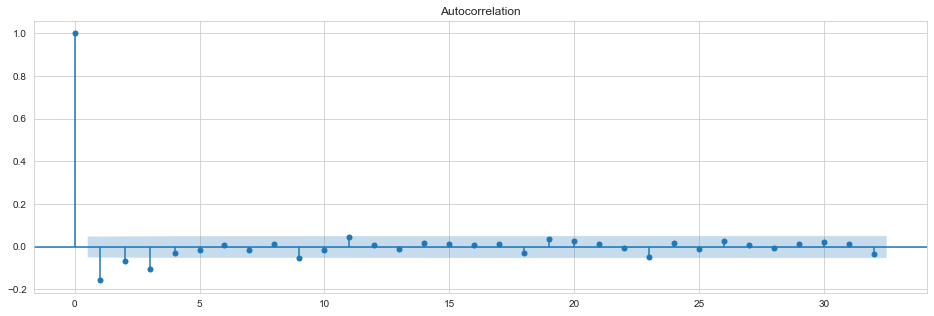

In [189]:
plot_acf(df_uni_diff)
plt.show()

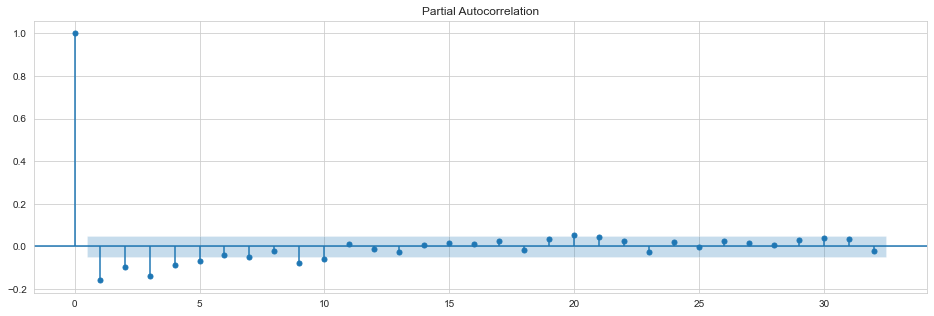

In [190]:
plot_pacf(df_uni_diff)
plt.show()

###### Inference : In the acf plot apart from lag 1 most of the lags are highly insignificant so the parameter q=1 and in the pacf plot the lags after lag 1 are trending towards insignificancy  so considering the parameter p=1 .Further building an ARMA model with AR(1) and MA(1).

## Defining Functions to obtain scores:

In [191]:
score_card1=pd.DataFrame(columns=['Model','RMSE','MAPE'])
def update_score_card1(algo_name,model):
    global score_card1
    
    def rmse(model):
        pred=model.forecast(steps=len(test))
        rmse=mean_squared_error(test,pred[0],squared=False)
        return rmse
    
    def mape(model):
        pred=model.forecast(steps=len(test))
        mape=mean_absolute_percentage_error(test,pred[0])
        return mape
    
    score_card1=score_card1.append({'Model':algo_name,'RMSE':rmse(model),'MAPE':mape(model)},ignore_index=True)
    return score_card1

## Forecasting with ARMA:

In [192]:
arma=ARMA(train,(1,1))
arma_model=arma.fit()
arma_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               meantemp   No. Observations:                 1095
Model:                     ARMA(1, 1)   Log Likelihood               -2095.615
Method:                       css-mle   S.D. of innovations              1.638
Date:                Mon, 17 May 2021   AIC                           4199.230
Time:                        21:54:04   BIC                           4219.224
Sample:                    01-01-2013   HQIC                          4206.796
                         - 12-31-2015                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             23.4821      2.747      8.547      0.000      18.097      28.867
ar.L1.meantemp     0.9865      0.005    187.616      0.000       0.976       0.997
ma.L1.meantemp    -0.2181      0.036     -6.040      0.000      -0.289      -0.147
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0137           +0.0000j            1.0137            0.0000
MA.1            4.5849           +0.0000j            4.5849            0.0000
-----------------------------------------------------------------------------
"""

###### Inference: As per the summary sheet we can see the Log Likelihood as -2078.858 and as per the p-values , all the parameters are significant.

In [194]:
update_score_card1("ARMA(1,1)",arma_model)

,Model,RMSE,MAPE
0,"ARMA(1,1)",7.700746,0.259763


###### Inference: With ARMA (1,1) model we get an RMSE of 7.7 and an MAPE score of 0.25 . Also the qqplot shows that thhe residuals are almost normally distributed.

## Forecasting with ARIMA:

### Obtaining the order for ARIMA with the lowest Akaike Information Criterion (AIC):

In [195]:
p=q=range(0,3)
d=(1,2)
pdq=list(itertools.product(p,d,q))
print("Parameter combination for model:\n")
for i in range(len(pdq)):
    print("Model: {}".format(pdq[i]))

Parameter combination for model:

Model: (0, 1, 0)
Model: (0, 1, 1)
Model: (0, 1, 2)
Model: (0, 2, 0)
Model: (0, 2, 1)
Model: (0, 2, 2)
Model: (1, 1, 0)
Model: (1, 1, 1)
Model: (1, 1, 2)
Model: (1, 2, 0)
Model: (1, 2, 1)
Model: (1, 2, 2)
Model: (2, 1, 0)
Model: (2, 1, 1)
Model: (2, 1, 2)
Model: (2, 2, 0)
Model: (2, 2, 1)
Model: (2, 2, 2)


In [196]:
# Dataframe to store the score of different parameters
param_df=pd.DataFrame(columns=['param','AIC'])
param_df

,param,AIC


In [197]:
for param in pdq:
    try:
        arima=ARIMA(train,order=param)
        result_arima=arima.fit()
        print("ARIMA{} = AIC:{}".format(param,result_arima.aic))
        param_df = param_df.append({'param':param, 'AIC': result_arima.aic}, ignore_index=True)
    except:
        continue

ARIMA(0, 1, 0) = AIC:4237.412241095645
ARIMA(0, 1, 1) = AIC:4196.922427255302
ARIMA(0, 1, 2) = AIC:4179.310088891746
ARIMA(0, 2, 0) = AIC:5163.445047115002
ARIMA(0, 2, 1) = AIC:4242.931160563048
ARIMA(0, 2, 2) = AIC:4202.504175680509
ARIMA(1, 1, 0) = AIC:4206.9716375512435
ARIMA(1, 1, 1) = AIC:4160.729680731958
ARIMA(1, 1, 2) = AIC:4162.728811781113
ARIMA(1, 2, 0) = AIC:4784.808509853347
ARIMA(2, 1, 0) = AIC:4197.192457529589
ARIMA(2, 1, 1) = AIC:4162.728658732429
ARIMA(2, 1, 2) = AIC:4163.066909163497
ARIMA(2, 2, 0) = AIC:4662.34003077832


In [198]:
param_df.sort_values(by=['AIC'])

,param,AIC
7,"(1, 1, 1)",4160.729681
11,"(2, 1, 1)",4162.728659
8,"(1, 1, 2)",4162.728812
12,"(2, 1, 2)",4163.066909
2,"(0, 1, 2)",4179.310089
1,"(0, 1, 1)",4196.922427
10,"(2, 1, 0)",4197.192458
5,"(0, 2, 2)",4202.504176
6,"(1, 1, 0)",4206.971638
0,"(0, 1, 0)",4237.412241


###### Inference: Since we get the lowest AIC score using parameters (1,1,1) ,we use it for forecasting.

In [199]:
arima=ARIMA(train,order=(1,1,1))
arima_res=arima.fit()
arima_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:             D.meantemp   No. Observations:                 1094
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2076.365
Method:                       css-mle   S.D. of innovations              1.614
Date:                Mon, 17 May 2021   AIC                           4160.730
Time:                        21:54:36   BIC                           4180.720
Sample:                    01-02-2013   HQIC                          4168.294
                         - 12-31-2015                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0050      0.023      0.217      0.828      -0.040       0.051
ar.L1.D.meantemp     0.5661      0.053     10.686      0.000       0.462       0.670
ma.L1.D.meantemp    -0.7942      0.038    -20.991      0.000      -0.868      -0.720
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.7665           +0.0000j            1.7665            0.0000
MA.1            1.2591           +0.0000j            1.2591            0.0000
-----------------------------------------------------------------------------
"""

##### Inference: Here we get a very slight decrease in Log Likelihood .

In [200]:
update_score_card1("ARIMA(1,1,1)",arima_res)

,Model,RMSE,MAPE
0,"ARMA(1,1)",7.700746,0.259763
1,"ARIMA(1,1,1)",12.193262,0.351651


###### Inference: In comparison with ARMA model the ARIMA model did not perform better.

## Forecasting using SARIMA :

###### Including the seasonal component for model building

In [98]:
p=q=range(0,3)
d=(1,2)
pdq=list(itertools.product(p,d,q))
model_pdq=[(x[0],x[1],x[2],12)for x in pdq]
print(" Examples of Model combination of parameters:\n")
print("Model : {}{}".format(pdq[0],model_pdq[0]))
print("Model : {}{}".format(pdq[1],model_pdq[1]))
print("Model : {}{}".format(pdq[1],model_pdq[2]))
print("Model : {}{}".format(pdq[3],model_pdq[0]))

 Examples of Model combination of parameters:

Model : (0, 1, 0)(0, 1, 0, 12)
Model : (0, 1, 1)(0, 1, 1, 12)
Model : (0, 1, 1)(0, 1, 2, 12)
Model : (0, 2, 0)(0, 1, 0, 12)


In [100]:
# Dataframe to store the AIC scores
df_para_s=pd.DataFrame(columns=['param','seasonal','AIC'])
df_para_s

,param,seasonal,AIC


In [107]:
for param in pdq:
    for seasonal in model_pdq:
        try:
            sarima=SARIMAX(train,order=param,seasonal_order=seasonal,enforce_stationarity=False,enforce_invertibility=False)
            res_sarima=sarima.fit()
            print('SARIMA{}x{}12 - AIC:{}'.format(param,seasonal, res_sarima.aic))
            df_para_s = df_para_s.append({'param':param,'seasonal':seasonal ,'AIC': res_sarima.aic}, ignore_index=True)
        except:
            continue

SARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:4919.204594212356
SARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:4174.5910052489035
SARIMA(0, 1, 0)x(0, 1, 2, 12)12 - AIC:4115.654964008471
SARIMA(0, 1, 0)x(0, 2, 0, 12)12 - AIC:6039.468880600914
SARIMA(0, 1, 0)x(0, 2, 1, 12)12 - AIC:4852.626878564093
SARIMA(0, 1, 0)x(0, 2, 2, 12)12 - AIC:4196.759651177013
SARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:4551.537247665652
SARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:4170.364280594413
SARIMA(0, 1, 0)x(1, 1, 2, 12)12 - AIC:4117.463159296782
SARIMA(0, 1, 0)x(1, 2, 0, 12)12 - AIC:5357.517211847538
SARIMA(0, 1, 0)x(1, 2, 1, 12)12 - AIC:4563.082567147736
SARIMA(0, 1, 0)x(1, 2, 2, 12)12 - AIC:4190.778696652927
SARIMA(0, 1, 0)x(2, 1, 0, 12)12 - AIC:4359.405380953358
SARIMA(0, 1, 0)x(2, 1, 1, 12)12 - AIC:4118.689170970929
SARIMA(0, 1, 0)x(2, 1, 2, 12)12 - AIC:4117.504611185278
SARIMA(0, 1, 0)x(2, 2, 0, 12)12 - AIC:4976.527706499372
SARIMA(0, 1, 0)x(2, 2, 1, 12)12 - AIC:4377.574993480694
SARIMA(0, 1, 0)x(2, 2, 2, 12)12 - AIC:4195.8181

SARIMA(1, 1, 2)x(0, 2, 0, 12)12 - AIC:5849.692061610486
SARIMA(1, 1, 2)x(0, 2, 1, 12)12 - AIC:4712.936952599459
SARIMA(1, 1, 2)x(0, 2, 2, 12)12 - AIC:4114.194789291865
SARIMA(1, 1, 2)x(1, 1, 0, 12)12 - AIC:4442.583119600112
SARIMA(1, 1, 2)x(1, 1, 1, 12)12 - AIC:4090.7874026888767
SARIMA(1, 1, 2)x(1, 1, 2, 12)12 - AIC:4036.873764483721
SARIMA(1, 1, 2)x(1, 2, 0, 12)12 - AIC:5204.124662052504
SARIMA(1, 1, 2)x(1, 2, 1, 12)12 - AIC:4451.755197857298
SARIMA(1, 1, 2)x(1, 2, 2, 12)12 - AIC:4109.505188658176
SARIMA(1, 1, 2)x(2, 1, 0, 12)12 - AIC:4254.121240878685
SARIMA(1, 1, 2)x(2, 1, 1, 12)12 - AIC:4045.5105756662883
SARIMA(1, 1, 2)x(2, 1, 2, 12)12 - AIC:4038.8736797859156
SARIMA(1, 1, 2)x(2, 2, 0, 12)12 - AIC:4826.357937648379
SARIMA(1, 1, 2)x(2, 2, 1, 12)12 - AIC:4273.032304508202
SARIMA(1, 1, 2)x(2, 2, 2, 12)12 - AIC:4107.445151287448
SARIMA(1, 2, 0)x(0, 1, 0, 12)12 - AIC:5452.632159042954
SARIMA(1, 2, 0)x(0, 1, 1, 12)12 - AIC:4716.571457025323
SARIMA(1, 2, 0)x(0, 1, 2, 12)12 - AIC:4654.11

SARIMA(2, 2, 1)x(1, 1, 0, 12)12 - AIC:4514.4578264347
SARIMA(2, 2, 1)x(1, 1, 1, 12)12 - AIC:4138.49526327932
SARIMA(2, 2, 1)x(1, 1, 2, 12)12 - AIC:4084.160924815601
SARIMA(2, 2, 1)x(1, 2, 0, 12)12 - AIC:5320.290071004151
SARIMA(2, 2, 1)x(1, 2, 1, 12)12 - AIC:4537.894734114725
SARIMA(2, 2, 1)x(1, 2, 2, 12)12 - AIC:4163.489965158859
SARIMA(2, 2, 1)x(2, 1, 0, 12)12 - AIC:4319.396686205414
SARIMA(2, 2, 1)x(2, 1, 1, 12)12 - AIC:4084.5515974584123
SARIMA(2, 2, 1)x(2, 1, 2, 12)12 - AIC:4087.151590756278
SARIMA(2, 2, 1)x(2, 2, 0, 12)12 - AIC:4935.441654630188
SARIMA(2, 2, 1)x(2, 2, 1, 12)12 - AIC:4343.632818856669
SARIMA(2, 2, 1)x(2, 2, 2, 12)12 - AIC:4165.267723666579
SARIMA(2, 2, 2)x(0, 1, 0, 12)12 - AIC:4782.462350952135
SARIMA(2, 2, 2)x(0, 1, 1, 12)12 - AIC:4085.0116270610306
SARIMA(2, 2, 2)x(0, 1, 2, 12)12 - AIC:4029.388391038325
SARIMA(2, 2, 2)x(0, 2, 0, 12)12 - AIC:5915.154696250798
SARIMA(2, 2, 2)x(0, 2, 1, 12)12 - AIC:4727.75057951861
SARIMA(2, 2, 2)x(0, 2, 2, 12)12 - AIC:4112.0022081

In [108]:
df_para_s.sort_values(by=['AIC'])

,param,seasonal,AIC
200,"(1, 2, 2)","(0, 1, 2, 12)",4025.801798
308,"(2, 2, 2)","(0, 1, 2, 12)",4029.388391
206,"(1, 2, 2)","(1, 1, 2, 12)",4029.734835
314,"(2, 2, 2)","(1, 1, 2, 12)",4031.251619
212,"(1, 2, 2)","(2, 1, 2, 12)",4032.501702
...,...,...,...
3,"(0, 1, 0)","(0, 2, 0, 12)",6039.468881
63,"(0, 2, 0)","(1, 2, 0, 12)",6232.527247
273,"(2, 2, 0)","(0, 2, 0, 12)",6436.742077
165,"(1, 2, 0)","(0, 2, 0, 12)",6565.346861


In [127]:
sarima=SARIMAX(train,order=(1, 2, 2),seasonal_order=(0, 1, 2, 12),enforce_stationarity=False,enforce_invertibility=False)
sarima_res=sarima.fit()

In [128]:
sarima_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                           meantemp   No. Observations:                 1095
Model:             SARIMAX(1, 2, 2)x(0, 1, 2, 12)   Log Likelihood               -2006.901
Date:                            Mon, 17 May 2021   AIC                           4025.802
Time:                                    21:33:47   BIC                           4055.564
Sample:                                01-01-2013   HQIC                          4037.085
                                     - 12-31-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6814      0.035     19.505      0.000       0.613       0.750
ma.L1         -1.9039      0.022    -87.644      0.000      -1.946      -1.861
ma.L2          0.9085      0.022     42.158      0.000       0.866       0.951
ma.S.L12      -0.9941      0.029    -34.140      0.000      -1.051      -0.937
ma.S.L24       0.0088      0.027      0.332      0.740      -0.043       0.061
sigma2         2.5488      0.087     29.405      0.000       2.379       2.719
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               299.46
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.03   Skew:                            -0.67
Prob(H) (two-sided):                  0.79   Kurtosis:                         5.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

###### Inference:The Log Likelihood has increased from the previous model 

In [131]:
pred=sarima_res.forecast(steps=len(test))

In [201]:
score_card2=pd.DataFrame(columns=['Model','RMSE','MAPE'])
score_card2=score_card2.append({"Model":"SARIMAX(1, 2, 2)x(0, 1, 2, 12)","RMSE":mean_squared_error(test,pred,squared=False),
                               "MAPE":mean_absolute_percentage_error(test,pred)},ignore_index=True)

In [203]:
score_card2

,Model,RMSE,MAPE
0,"SARIMAX(1, 2, 2)x(0, 1, 2, 12)",62.623905,2.335031


###### Inference: SARIMAX give a bad model since the scores are much higher than the previous models.

In [218]:
ARMA_pred=arma_model.forecast(steps=len(test))
ARIMA_pred=arima_res.forecast(steps=len(test))
SARIMA_pred=sarima_res.forecast(steps=len(test))

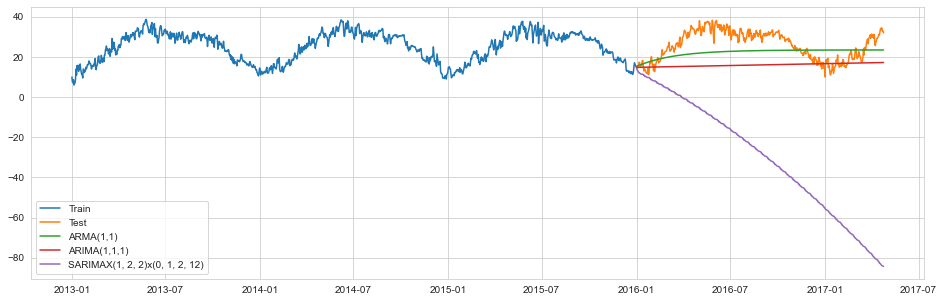

In [220]:
plt.plot(train,label='Train')
plt.plot(test,label='Test')
plt.plot(test.index,ARMA_pred[0],label='ARMA(1,1)')
plt.plot(test.index,ARIMA_pred[0],label='ARIMA(1,1,1)')
plt.plot(test.index,SARIMA_pred,label='SARIMAX(1, 2, 2)x(0, 1, 2, 12)')
plt.legend()
plt.show()

###### Inference: We can see above the ARMA & ARIMA model do a good job but the SARIMAX model do a bad job at forcasting the climate.

In [232]:
df_score=pd.concat([score_card,score_card1,score_card2])
df_score=df_score.reset_index().drop(columns=['index'])
df_score.style.highlight_min(['MAPE'],'lightgreen')

,Model,RMSE,MAPE
0,Simple Exponential,12.656961,0.370264
1,Double Exponential,11.578032,0.332991
2,Triple Exponential Additive Seasonality,12.715798,0.372145
3,Triple Exponential Multiplicative Seasonality,12.683938,0.371105
4,"ARMA(1,1)",7.700746,0.259763
5,"ARIMA(1,1,1)",12.193262,0.351651
6,"SARIMAX(1, 2, 2)x(0, 1, 2, 12)",62.623905,2.335031


###### Inference : With respect to univariate forecasting using the mean temperature variable, the ARMA model with parameters p=1 and q=1 do the best job of forecasting the climate which gives the lowest RMSE score of 7.7 and the lowest MAPE score of 0.25.

## Multivariate Forecasting:

In [17]:
df_climate1=pd.read_csv("DailyDelhiClimateTrain.csv",parse_dates=['date'])

In [18]:
df_climate2=pd.read_csv("DailyDelhiClimateTest.csv",parse_dates=['date'])

In [19]:
df_climate=pd.concat([df_climate1,df_climate2])
df_climate.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [20]:
df_climate.set_index(['date'],inplace=True)

In [21]:
df_climate.sort_index(inplace=True)

In [22]:
df_climate.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [23]:
df_climate.tail()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2017-04-20,34.500,27.500000,5.562500,998.625000
2017-04-21,34.250,39.375000,6.962500,999.875000
2017-04-22,32.900,40.900000,8.890000,1001.600000
2017-04-23,32.875,27.500000,9.962500,1002.125000
2017-04-24,32.000,27.142857,12.157143,1004.142857


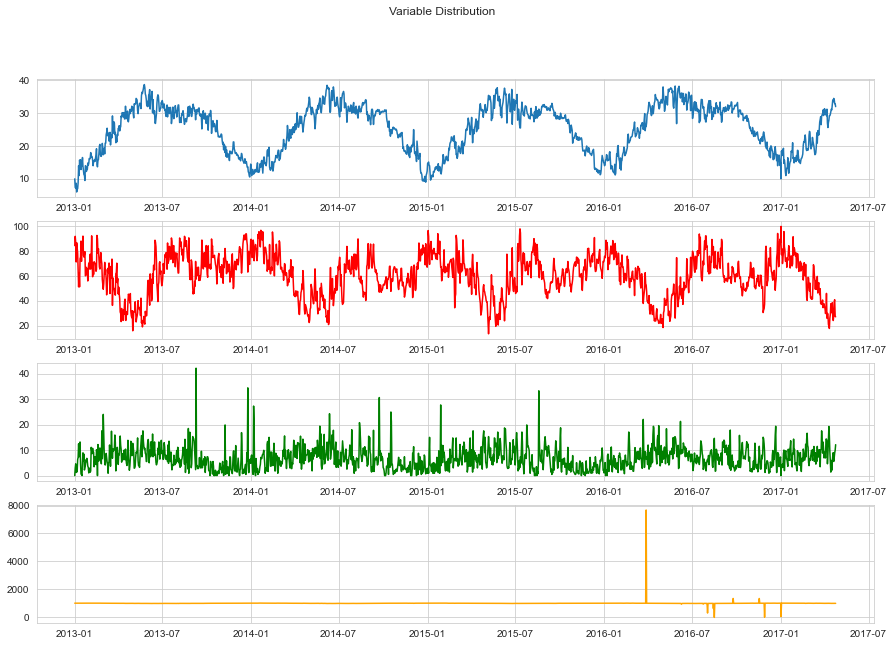

In [24]:
 fig,ax=plt.subplots(4,1,figsize=(15,10))
ax[0].plot(df_climate["meantemp"])
ax[1].plot(df_climate["humidity"],color='red')
plt.suptitle("Variable Distribution")
ax[2].plot(df_climate["wind_speed"],color='green')
ax[3].plot(df_climate["meanpressure"],color='orange')
plt.show()

###### Inference : In the plots above we can see some pattern in each of the variables .Also there seems to be some association between the variables with each other.

## Checking the relationship between the variables using Cointegration test:

In [34]:
out=coint_johansen(df_climate,-1,1)
out.lr1
out.cvt[:,[1]]

array([[40.1749],
       [24.2761],
       [12.3212],
       [ 4.1296]])

In [71]:
def coint(df,alpha=0.05):
    out=coint_johansen(df_climate,-1,1)
    d={"0.9":0,"0.95":1}
    traces=out.lr1
    cvts=out.cvt[:,d[str(1-alpha)]]
    
    def space(val,length=10):
        return str(val).ljust(length)
    
    print("Columns   ::   Test-Stat > Crit-Val(95%)  => Signi \n","--"*25)
    
    for col,trace,cv in zip(df.columns,traces,cvts):
        print(space(col,15), '::',space(round(trace,2),8),'>',space(cv,15),trace>cv)
coint(df_climate)
        

Columns   ::   Test-Stat > Crit-Val(95%)  => Signi 
 --------------------------------------------------
meantemp        :: 784.16   > 40.1749         True
humidity        :: 333.84   > 24.2761         True
wind_speed      :: 39.05    > 12.3212         True
meanpressure    :: 0.2      > 4.1296          False


###### Inference : Above we can state that the mean pressure is not related to any of the other variables with 95% confidence. So we dont consider mean pressure for forecasting.

In [75]:
df_multi=df_climate.drop(columns=['meanpressure'])
df_multi.head()

,meantemp,humidity,wind_speed
date,,,
2013-01-01,10.000000,84.500000,0.000000
2013-01-02,7.400000,92.000000,2.980000
2013-01-03,7.166667,87.000000,4.633333
2013-01-04,8.666667,71.333333,1.233333
2013-01-05,6.000000,86.833333,3.700000


## Splitting data into train and test:

In [76]:
train_end=datetime(2015,12,31)
test_end=datetime(2017,4,24)
train=df_multi[:train_end]
test=df_multi[train_end+timedelta(days=1):test_end]
print("Train:\n",train)
print("Test:\n",test)

Train:
              meantemp   humidity  wind_speed
date                                        
2013-01-01  10.000000  84.500000    0.000000
2013-01-02   7.400000  92.000000    2.980000
2013-01-03   7.166667  87.000000    4.633333
2013-01-04   8.666667  71.333333    1.233333
2013-01-05   6.000000  86.833333    3.700000
...               ...        ...         ...
2015-12-27  15.375000  63.250000    7.887500
2015-12-28  17.125000  58.125000   10.887500
2015-12-29  16.375000  65.000000    7.412500
2015-12-30  15.500000  71.750000    2.100000
2015-12-31  15.000000  71.375000    2.087500

[1095 rows x 3 columns]
Test:
              meantemp   humidity  wind_speed
date                                        
2016-01-01  14.714286  72.285714    1.057143
2016-01-02  14.000000  75.875000    2.087500
2016-01-03  14.375000  74.750000    5.112500
2016-01-04  15.750000  77.125000    0.000000
2016-01-05  15.833333  88.833333    0.616667
...               ...        ...         ...
2017-04-20  34.

In [77]:
def adfuller_test(series,name=''):
    observations= series.values
    test_result = adfuller(observations)
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print('ADF Statistic: %f' % test_result[0])
    print('p-value: %f' % test_result[1])
    print('Critical Values:')
    for key, value in test_result[4].items():
            	print('\t%s: %.5f' % (key, value))

In [78]:
for name, column in train.iteritems():
    adfuller_test(column,name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "meantemp" 
    -----------------------------------------------
ADF Statistic: -1.965668
p-value: 0.301826
Critical Values:
	1%: -3.43640
	5%: -2.86421
	10%: -2.56819


    Augmented Dickey-Fuller Test on "humidity" 
    -----------------------------------------------
ADF Statistic: -3.552799
p-value: 0.006730
Critical Values:
	1%: -3.43640
	5%: -2.86421
	10%: -2.56819


    Augmented Dickey-Fuller Test on "wind_speed" 
    -----------------------------------------------
ADF Statistic: -3.938237
p-value: 0.001771
Critical Values:
	1%: -3.43645
	5%: -2.86423
	10%: -2.56820




###### Inference: The mean temperature is not stationary so differencing is applied.

In [79]:
df_differenced = train.diff().dropna()

In [80]:
for name, column in df_differenced.iteritems():
    adfuller_test(column,name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "meantemp" 
    -----------------------------------------------
ADF Statistic: -12.409536
p-value: 0.000000
Critical Values:
	1%: -3.43640
	5%: -2.86421
	10%: -2.56819


    Augmented Dickey-Fuller Test on "humidity" 
    -----------------------------------------------
ADF Statistic: -10.575483
p-value: 0.000000
Critical Values:
	1%: -3.43644
	5%: -2.86423
	10%: -2.56820


    Augmented Dickey-Fuller Test on "wind_speed" 
    -----------------------------------------------
ADF Statistic: -12.685192
p-value: 0.000000
Critical Values:
	1%: -3.43647
	5%: -2.86424
	10%: -2.56821




###### Inference: All the time series are stationary as per adf test.

## Select the right order of the VAR model for least AIC:

In [84]:
model = VAR(df_differenced)
for i in range(1,30):
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)

Lag Order = 1
AIC :  7.799197208923804
Lag Order = 2
AIC :  7.675517470679813
Lag Order = 3
AIC :  7.5745556610006615
Lag Order = 4
AIC :  7.5415623323703365
Lag Order = 5
AIC :  7.524625163742048
Lag Order = 6
AIC :  7.512084398911663
Lag Order = 7
AIC :  7.504636371276086
Lag Order = 8
AIC :  7.49471577846035
Lag Order = 9
AIC :  7.486248926967133
Lag Order = 10
AIC :  7.464891116959629
Lag Order = 11
AIC :  7.456619233813689
Lag Order = 12
AIC :  7.464057860965546
Lag Order = 13
AIC :  7.473806733339942
Lag Order = 14
AIC :  7.480768831473541
Lag Order = 15
AIC :  7.471717163925371
Lag Order = 16
AIC :  7.483131384965258
Lag Order = 17
AIC :  7.485595438965646
Lag Order = 18
AIC :  7.487756445092934
Lag Order = 19
AIC :  7.486165233296798
Lag Order = 20
AIC :  7.490838009935128
Lag Order = 21
AIC :  7.498469341338013
Lag Order = 22
AIC :  7.504345071788485
Lag Order = 23
AIC :  7.512650020287895
Lag Order = 24
AIC :  7.517088947772119
Lag Order = 25
AIC :  7.531005073199727
Lag Orde

###### Inference: Considering lag 3 for model building.

## Train the VAR model for selected order:

In [85]:
model_fitted = model.fit(3)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 19, May, 2021
Time:                     10:04:18
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    7.71190
Nobs:                     1091.00    HQIC:                   7.62654
Log likelihood:          -8746.11    FPE:                    1948.00
AIC:                      7.57456    Det(Omega_mle):         1895.40
--------------------------------------------------------------------
Results for equation meantemp
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 0.009336         0.049074            0.190           0.849
L1.meantemp          -0.176254         0.039313           -4.483           0.000
L1.humidity           0.008197         0.008020          

## Forecasting :

In [86]:
forecast_input = df_differenced.values[-3:]
forecast_input

array([[-0.75  ,  6.875 , -3.475 ],
       [-0.875 ,  6.75  , -5.3125],
       [-0.5   , -0.375 , -0.0125]])

In [94]:
forecast=model_fitted.forecast(y=forecast_input,steps=len(test))
forecast=pd.DataFrame(forecast,index=df_multi.index[-481:], columns=df_multi.columns)

In [95]:
forecast

,meantemp,humidity,wind_speed
date,,,
2016-01-01,0.408796,-2.832407,2.428146
2016-01-02,0.072868,-0.154538,-0.285319
2016-01-03,-0.010497,0.751402,-0.815146
2016-01-04,-0.033524,0.236470,0.061445
2016-01-05,0.021417,-0.177859,0.330752
...,...,...,...
2017-04-20,0.006257,-0.007041,0.001294
2017-04-21,0.006257,-0.007041,0.001294
2017-04-22,0.006257,-0.007041,0.001294


In [97]:
def invert_transformation(train, forecast):
    df_fc = forecast.copy()
    columns = train.columns
    for col in columns:        
        df_fc[str(col)+'_forecast'] = train[col].iloc[-1] + df_fc[str(col)].cumsum()
    return df_fc
df_results = invert_transformation(train,forecast)

In [98]:
df_results.head()

,meantemp,humidity,wind_speed,meantemp_forecast,humidity_forecast,wind_speed_forecast
date,,,,,,
2016-01-01,0.408796,-2.832407,2.428146,15.408796,68.542593,4.515646
2016-01-02,0.072868,-0.154538,-0.285319,15.481664,68.388055,4.230327
2016-01-03,-0.010497,0.751402,-0.815146,15.471166,69.139457,3.415181
2016-01-04,-0.033524,0.236470,0.061445,15.437642,69.375927,3.476627
2016-01-05,0.021417,-0.177859,0.330752,15.459059,69.198068,3.807379


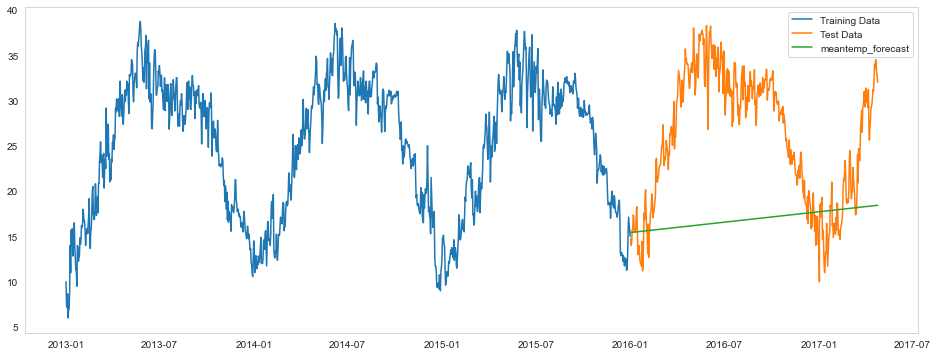

In [101]:
rcParams['figure.figsize']=16,6
plt.plot(train['meantemp'],label='Training Data')
plt.plot(test['meantemp'],label='Test Data')
plt.plot(test.index,df_results['meantemp_forecast'],label='meantemp_forecast')
plt.legend(loc='best')
plt.grid();

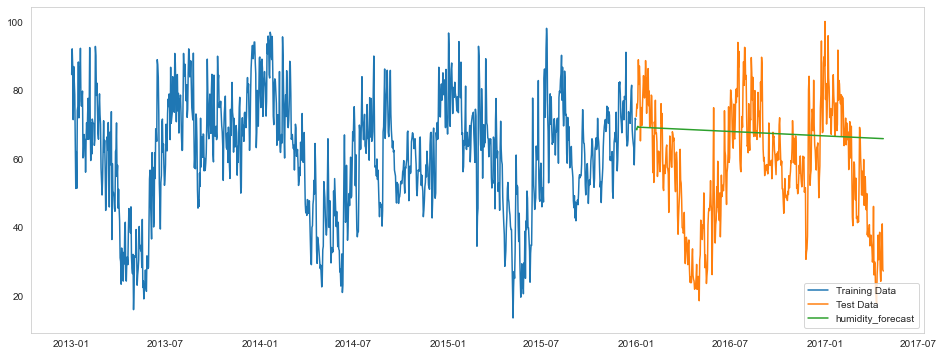

In [102]:
plt.plot(train['humidity'],label='Training Data')
plt.plot(test['humidity'],label='Test Data')
plt.plot(test.index,df_results['humidity_forecast'],label='humidity_forecast')
plt.legend(loc='best')
plt.grid();

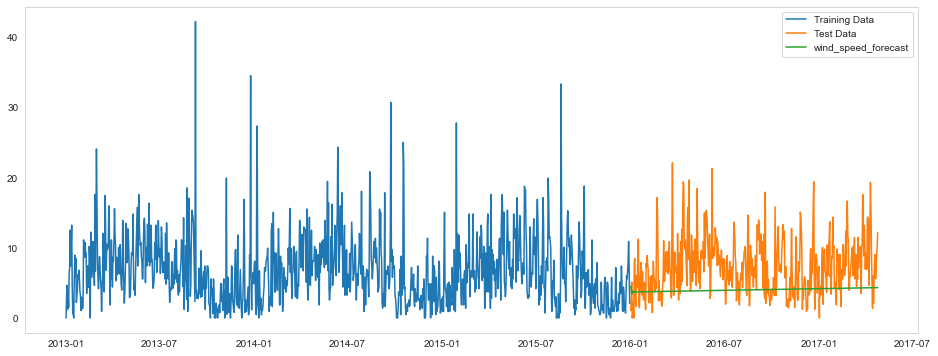

In [103]:
plt.plot(train['wind_speed'],label='Training Data')
plt.plot(test['wind_speed'],label='Test Data')
plt.plot(test.index,df_results['wind_speed_forecast'],label='wind_speed_forecast')
plt.legend(loc='best')
plt.grid();

## Obtaining scores :

In [106]:
def MAPE(y_true, y_pred):
    return np.mean((np.abs(y_true-y_pred))/(y_true))*100

In [107]:
mape=MAPE(test['meantemp'].values,df_results['meantemp_forecast'].values)
print(mape)

33.07894903814


In [108]:
mape=MAPE(test['humidity'].values,df_results['humidity_forecast'].values)
print(mape)

37.91492133018193


In [109]:
mape=MAPE(test['wind_speed'].values,df_results['wind_speed_forecast'].values)
print(mape)

inf


In [110]:
from sklearn.metrics import  mean_squared_error
rmse = mean_squared_error(test['meantemp'].values,df_results['meantemp_forecast'].values,squared=False)
print(rmse)

11.498175357984804


In [111]:
rmse = mean_squared_error(test['humidity'].values,df_results['humidity_forecast'].values,squared=False)
print(rmse)

19.5396955173649


In [112]:
rmse = mean_squared_error(test['wind_speed'].values,df_results['wind_speed_forecast'].values,squared=False)
print(rmse)

5.166011844417662


 ###### Inference : As per the calculated scores we get least mape for mean temperature and least rmse for wind speed.